In [1]:
#@title Download Dataset
!gdown --fuzzy https://drive.google.com/file/d/1Z8RO6tidqQMdDZo8td-nNPBRc1SszGkA/view?usp=drive_link -O ds811_lettuce.zip

!unzip /content/ds811_lettuce.zip -d /content

Downloading...
From: https://drive.google.com/uc?id=1Z8RO6tidqQMdDZo8td-nNPBRc1SszGkA
To: /content/ds811_lettuce.zip
100% 5.81M/5.81M [00:00<00:00, 125MB/s]
Archive:  /content/ds811_lettuce.zip
   creating: /content/ds811_lettuce/
   creating: /content/ds811_lettuce/test/
   creating: /content/ds811_lettuce/test/Mildew/
  inflating: /content/ds811_lettuce/test/Mildew/lmild(87).jpg  
  inflating: /content/ds811_lettuce/test/Mildew/lmild(71).jpg  
  inflating: /content/ds811_lettuce/test/Mildew/lmild(57).jpg  
  inflating: /content/ds811_lettuce/test/Mildew/lmild(13).jpg  
  inflating: /content/ds811_lettuce/test/Mildew/lmild(2).jpg  
  inflating: /content/ds811_lettuce/test/Mildew/lmild(21).jpg  
  inflating: /content/ds811_lettuce/test/Mildew/lmild(40).jpg  
  inflating: /content/ds811_lettuce/test/Mildew/lmild(53).jpg  
  inflating: /content/ds811_lettuce/test/Mildew/lmild(15).jpg  
   creating: /content/ds811_lettuce/test/MinNutrition/
  inflating: /content/ds811_lettuce/test/MinNutr

In [2]:
#@title Import Library
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Augmentasi gambar
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

# Evaluasi confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import files
from tensorflow.keras.models import load_model


In [3]:
# @title Pengaturan Keras agar hasil dapat direproduksi kembali

import random
SEED = 0

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

In [4]:
#@title Fungsi Ambil direktori Dataset
def get_path_ds(data_dir):
  train_dir = f'{data_dir}/train'
  test_dir = f'{data_dir}/test'

  return train_dir, test_dir

In [5]:
#@title Fungsi Augmentasi
def augmentation_ds(val_split):
  aug_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=val_split
  )

  aug_val = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1.0 / 255,
      validation_split=val_split
  )

  rescale_test = rescale = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1.0 / 255
  )


  return aug_train, aug_val, rescale_test


In [6]:
#@title Persiapan Dataset untuk Data latih
def preparing_ds(function, bs, ts, cm = "sparse", trdir='', tsdir=''):

   aug_train, aug_val, rescale_test = function()

   train_ds = aug_train.flow_from_directory(
        trdir,
        target_size=ts,
        batch_size=bs,
        class_mode= cm,
        shuffle=True,
        seed=123,
        subset="training"
    )

   val_ds = aug_val.flow_from_directory(
        trdir,
        target_size =ts,
        batch_size =bs,
        class_mode= cm,
        shuffle=True,
        seed=123,
        subset="validation"
    )

   test_ds = rescale_test.flow_from_directory(
        tsdir,
        batch_size = bs,
        target_size= ts,
        shuffle = False
    )

   classes = list(train_ds.class_indices.keys())

   n_classes = train_ds.num_classes

   return train_ds, val_ds, test_ds, classes, n_classes


In [7]:
#@title Fungsi Kurva Pembelajaran & Confusion Matrix
def learning_curve(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))
  fig = plt.figure(figsize=(15,10))
  grid = plt.GridSpec(2, 2, wspace=0.2, hspace = 0.3, figure =fig)

  plt.subplot(grid[0,0])
  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.legend()

  plt.subplot(grid[0,1])
  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and Validation loss')
  plt.legend()

  # menampilkan grafik
  plt.show()

def evaluation_confusion_matrix(model, data):
  # test_steps_per_epoch = np.math.ceil(data.samples / data.batch_size)
  predictions = model.predict(data, verbose=0)

  # Get most likely class
  predicted_classes = np.argmax(predictions, axis=1)

  true_classes = data.classes
  class_labels = list(data.class_indices.keys())
  cf_matrix = confusion_matrix(true_classes, predicted_classes)
  report_cf_matrix = classification_report(true_classes, predicted_classes, target_names=class_labels)

  return cf_matrix, report_cf_matrix

def cf_matrix_heatmap(cf_matrix, classes):
  plt.figure(figsize=(12,8))
  sns.set(font_scale=0.7)
  ax=sns.heatmap(cf_matrix, annot=True, cmap='Greens')

  # set x-axis label and title
  ax.set_xlabel("Prediksi", fontsize=10, labelpad=2)
  ax.xaxis.set_ticklabels(classes)

  # set y-axis label and title
  ax.set_ylabel("Aktual", fontsize=10, labelpad=2)
  ax.yaxis.set_ticklabels(classes)

  ax.set_title("Confusion Matrix Kualitas Selada", fontsize=12, pad=14)

  plt.show()


In [8]:
#@title Ambil Direktori Dataset
train_dir_1, test_dir_1 = get_path_ds('/content/ds811_lettuce')

In [9]:
train_dir_1

'/content/ds811_lettuce/train'

In [10]:
test_dir_1

'/content/ds811_lettuce/test'

In [11]:
#@title Persiapan Dataset untuk Data Latih
train_ds_1, val_ds_1, test_ds_1, classes_1, n_classes_1 = preparing_ds(
    lambda : augmentation_ds(0.1),
    bs = 8,
    ts = (256,256),
    cm= "sparse",
    trdir = train_dir_1,
    tsdir= test_dir_1
)

Found 292 images belonging to 4 classes.
Found 31 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


In [12]:
#@title Menampilkan Kelas
classes_1

['Healthy', 'Mildew', 'MinNutrition', 'Rot']

In [13]:
#@title Arsitektur Model

# input_shape = (256,256,3)
# epochs_ = 50
# step_epoch = np.math.floor(train_ds_1.samples / train_ds_1.batch_size)
# val_step = np.math.floor(val_ds_1.samples/val_ds_1.batch_size)



# model_1 = tf.keras.models.Sequential([
#     layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
#     layers.MaxPool2D((2,2)),
#     layers.Dropout(0.2),
#     layers.Conv2D(64, (3,3), activation = 'relu'),
#     layers.MaxPool2D(2,2),
#     layers.Dropout(0.2),
#     layers.Conv2D(64,(3,3), activation = 'relu'),
#     layers.MaxPool2D(2,2),
#     layers.Flatten(),
#     layers.Dropout(0.3),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(n_classes_1, activation='softmax')
# ])

# # konfig

# model_1.compile(
#     loss = tf.keras.losses.SparseCategoricalCrossentropy(),
#     optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
#     metrics=['accuracy']
# )


# hist1 = model_1.fit(
#     train_ds_1,
#     validation_data= val_ds_1,
#     epochs= epochs_,
#     verbose = 1,
#     steps_per_epoch= step_epoch,
#     validation_steps= val_step
# )


In [14]:
#@title Download Model
!gdown --fuzzy https://drive.google.com/file/d/1USY1XwlqEp9lY3UZzQNbrJ4vBCuOqNrC/view?usp=sharing -O model_811.h5

Downloading...
From: https://drive.google.com/uc?id=1USY1XwlqEp9lY3UZzQNbrJ4vBCuOqNrC
To: /content/model_811.h5
100% 45.0M/45.0M [00:00<00:00, 57.8MB/s]


In [15]:
#@title Load Model

path_model='/content/model_811.h5'
model = load_model(path_model)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 62, 62, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 64)       

In [16]:
#@title Evaluasi Confusion Matrix
cf_matrix_1, report_cf_matrix_1 = evaluation_confusion_matrix(model, test_ds_1)

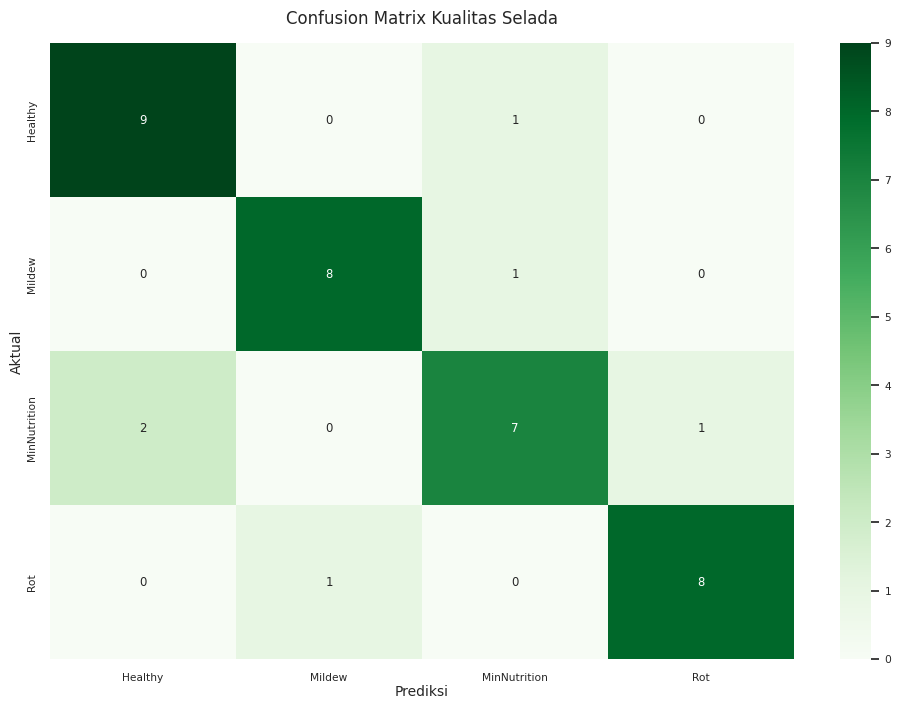

In [17]:
#@title Heatmap Hasil Evaluasi
cf_matrix_heatmap(cf_matrix_1, classes_1)

In [18]:
#@title Report Confusion Matrix
print(report_cf_matrix_1)

              precision    recall  f1-score   support

     Healthy       0.82      0.90      0.86        10
      Mildew       0.89      0.89      0.89         9
MinNutrition       0.78      0.70      0.74        10
         Rot       0.89      0.89      0.89         9

    accuracy                           0.84        38
   macro avg       0.84      0.84      0.84        38
weighted avg       0.84      0.84      0.84        38



In [19]:
# @title Input Gambar Selada

uploaded = files.upload()
for fn in uploaded.keys():
  path = fn
  img = tf.keras.utils.load_img(path, target_size=(256,256))
  x = tf.keras.utils.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x /= 255
  images = np.vstack([x])
  pred = model.predict(images, batch_size=8, verbose=0)
  plt.imshow(img)
  prediction = classes_1[np.argmax(pred)]
  confidence = round(100 * (np.max(pred[0])), 2)
  plt.title(f'Prediksi :  {prediction} \nKeyakinan : {confidence}%')
  plt.axis('off')


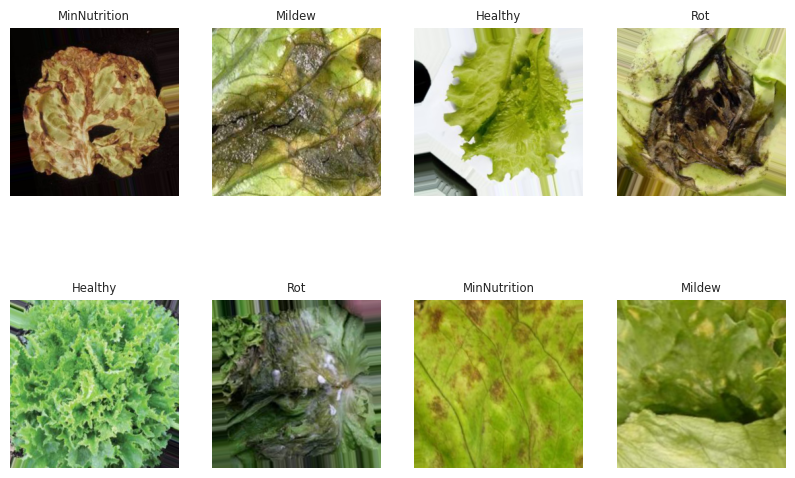

In [20]:
#@title Menampilkan Dataset Train
plt.figure(figsize=(10,10))
for image, label in train_ds_1:
  for i in range(8):
    ax = plt.subplot(3,4, i+1)
    plt.imshow(image[i])
    plt.title(classes_1[label[i].astype(int)])
    plt.axis('off')
  break

In [21]:
#@title Hasil Preprocessing

for image, label in train_ds_1:
  for i in range(1):
    # print(label[i])
    print(image[i])
  break

[[[0.40928978 0.30835733 0.23137257]
  [0.4267933  0.31757125 0.24807099]
  [0.41676998 0.30304447 0.24029939]
  ...
  [0.17639636 0.3267108  0.        ]
  [0.16937919 0.3185241  0.        ]
  [0.1863795  0.33122218 0.01775204]]

 [[0.40819404 0.30945307 0.23137257]
  [0.41693145 0.3099009  0.23711336]
  [0.43430224 0.32057673 0.25783163]
  ...
  [0.21263282 0.35129824 0.04400537]
  [0.23251478 0.3665021  0.06388733]
  [0.20611909 0.33744037 0.04956405]]

 [[0.41007787 0.31501824 0.23584194]
  [0.41124302 0.30640408 0.23137257]
  [0.4443726  0.33124402 0.26760352]
  ...
  [0.161334   0.28956667 0.02331074]
  [0.12741771 0.25331134 0.00342877]
  [0.10608328 0.22866997 0.        ]]

 ...

 [[0.7781417  0.70459974 0.43885064]
  [0.837625   0.7625102  0.49071178]
  [0.8738804  0.795257   0.51644135]
  ...
  [0.7273225  0.81781703 0.50170374]
  [0.70143914 0.7960785  0.44785032]
  [0.6943148  0.79309887 0.42074692]]

 [[0.9217541  0.8384977  0.5504163 ]
  [0.9519603  0.86568576 0.57140464]


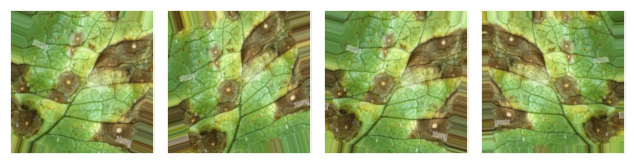

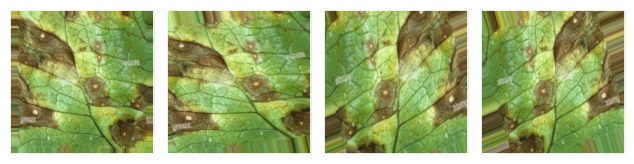

In [22]:
#@title Hasil Augmentasi

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# We pick one image to "augment"
img_path = '/content/ds811_lettuce/test/MinNutrition/lminnutr(15).jpg'

# Read the image and resize it
img = image.load_img(img_path, target_size=(256, 256))

# Convert it to a Numpy array with shape (256, 256, 3)
x = image.img_to_array(img)

# Reshape it to (1, 256, 256, 3)
x = x.reshape((1,) + x.shape)


datagen = ImageDataGenerator(
     rotation_range=20,
      zoom_range=0.2,
      horizontal_flip=True,
    )

# The .flow() command below generates batches of randomly transformed images.
# # It will loop indefinitely, so we need to `break` the loop at some point!
for i in range(2):
  i=0
  for batch in datagen.flow(x, batch_size=1):
    plt.subplot(141+i)
    plt.imshow(image.array_to_img(batch[0]))
    plt.xticks([])
    plt.yticks([])
    i+=1
    if i % 4 == 0:
      break
  plt.tight_layout()
  plt.show()



In [23]:
#@title Hasil Filter

from tensorflow.keras import models

img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor, verbose=0)


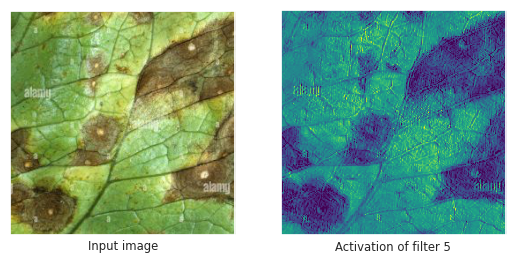

In [24]:
first_layer_activation = activations[0]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(img_tensor[0])
ax2.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_xlabel('Input image')
ax2.set_xlabel('Activation of filter 5');

In [35]:
#@title Fungsi Menampilkan Hasil Filter
images_per_row = 16

layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

def plot_activations(layer_index, activations):
    start = layer_index
    end = layer_index+1
    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names[start:end], activations[start:end]):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title("Activation of layer {} ({})".format(layer_index+1,layer_name), fontdict={'fontsize':15})
        plt.grid(False)
        plt.axis("off")
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()

In [36]:
# model.summary()

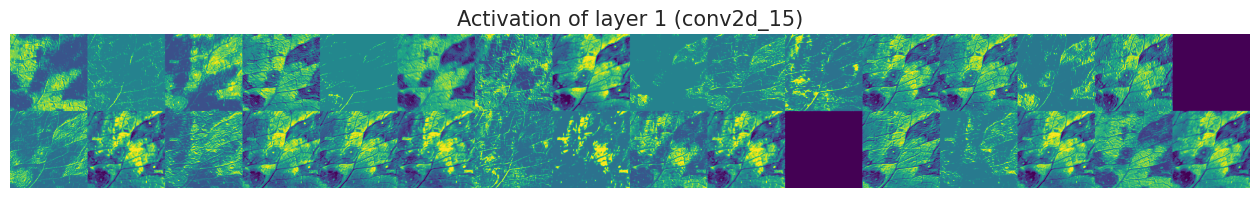

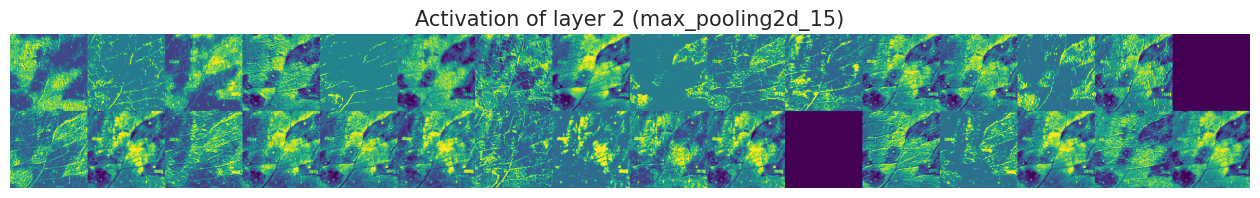

In [37]:
plot_activations(0, activations)
plot_activations(1, activations)

<ipython-input-35-4af338d93713>:31: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


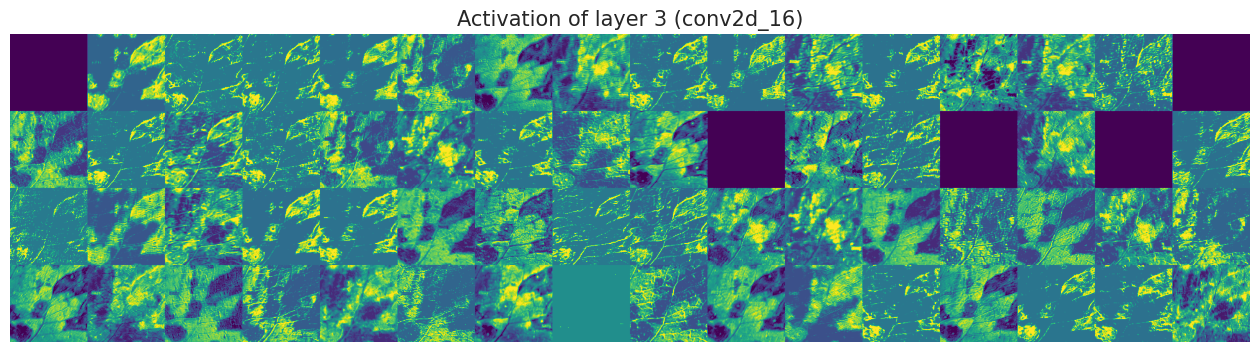

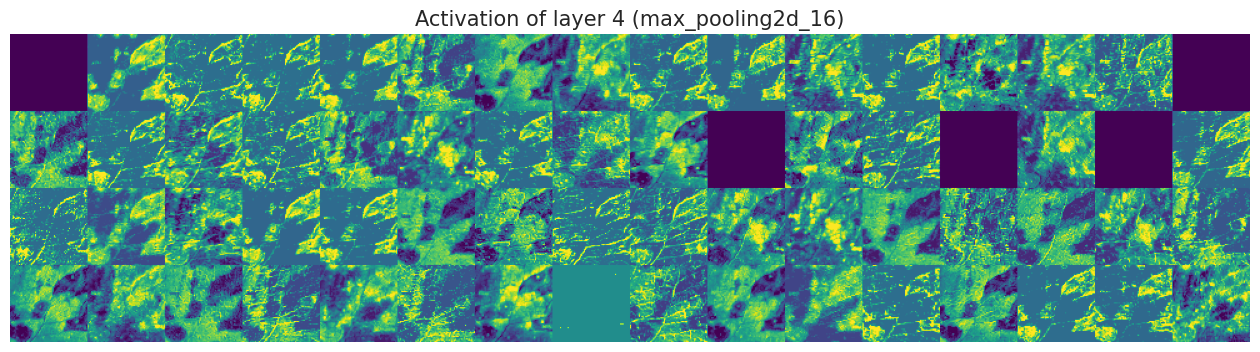

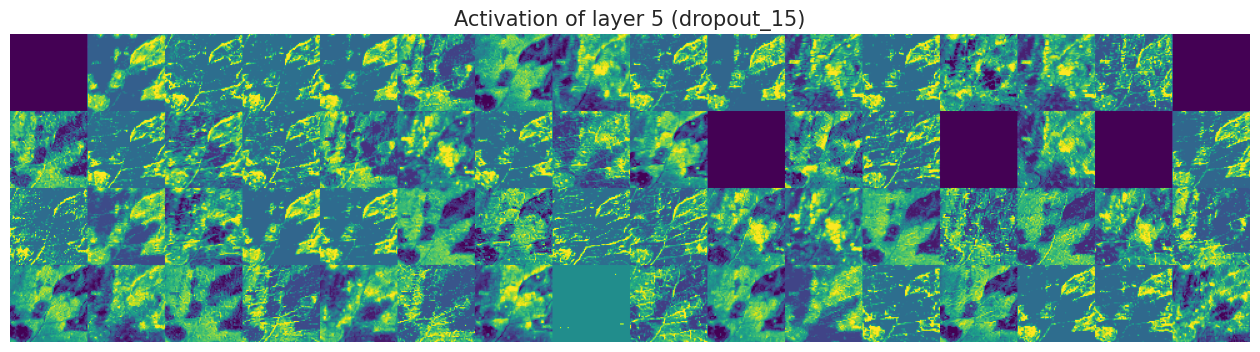

In [43]:
plot_activations(2, activations)
plot_activations(3, activations)
plot_activations(4, activations)

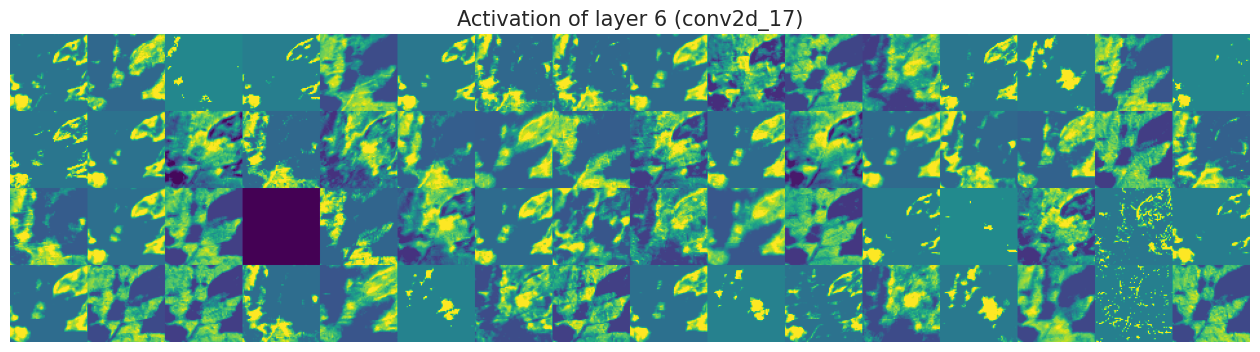

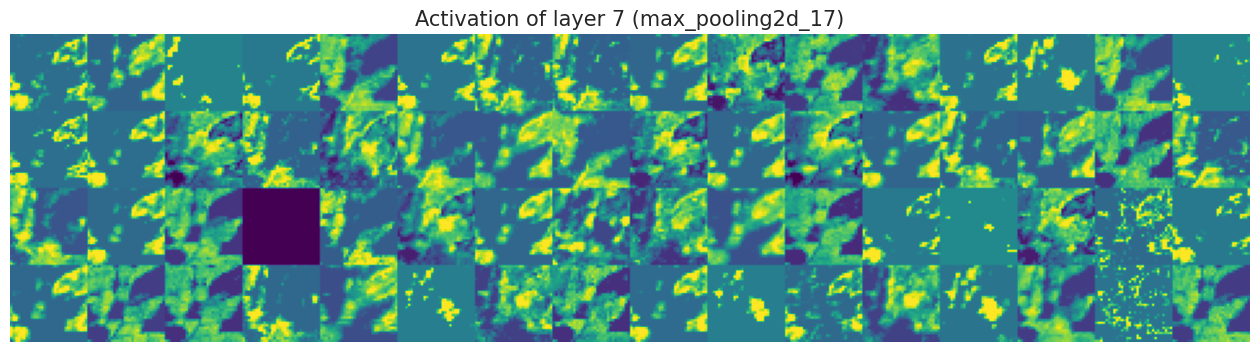

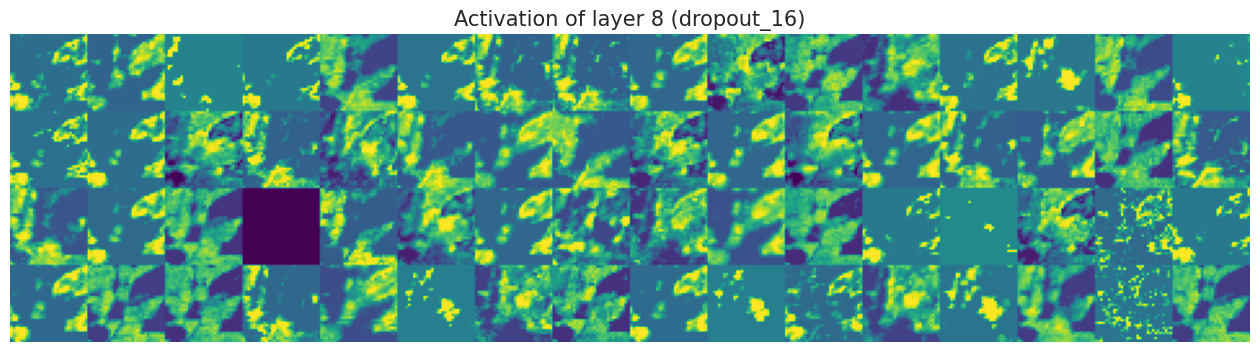

In [44]:
plot_activations(5, activations)
plot_activations(6, activations)
plot_activations(7, activations)

In [41]:
#@title Bobot Model
# model.get_weights()